# Reading in Data

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul 23 09:01:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make
print("done installing")

--2022-07-23 09:01:51--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0 [following]
--2022-07-23 09:01:51--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip.1’

0.2.0.zip.1             [  <=>               ]   4.10M  14.1MB/s    in 0.3s    

2022-07-23 09:01:51 (14.1 MB/s) - ‘0.2.0.zip.1’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
replace fastText-0.2.0/.circleci/cmake_test.sh? [y]es, [n]o, [A]ll, [N]on

In [5]:
import pandas as pd
import os
from typing import List, Tuple, Union

DIR = 'twitter-datasets'


def _read_data(path: str) -> List[str]:
  with open(path, 'r') as f:
    return [x for x in f]


def _read_data_with_ids(path: str) -> Tuple[List[str], List[str]]:
  index = []
  rows = []
  with open(path, 'r') as f:
    for line in f:
      id, x = line.split(',', maxsplit=1)
      index.append(id)
      rows.append(x)
  return index, rows


def load_train(full=False, dir=DIR, eval_frac=None, cols=None, neg_label=-1) -> Union[pd.DataFrame, Tuple[pd.DataFrame, pd.DataFrame]]:
    if cols is None:
        cols = ['x', 'y']
    pos_path = '/content/gdrive/MyDrive/train_pos.txt'
    neg_path = '/content/gdrive/MyDrive/train_neg.txt'
    pos_rows = _read_data(pos_path)
    pos = pd.DataFrame({cols[0]: pos_rows})
    pos[cols[1]] = 1

    neg_rows = _read_data(neg_path)
    neg = pd.DataFrame({cols[0]: neg_rows})
    neg[cols[1]] = neg_label

    df = pd.concat([pos, neg], ignore_index=True).reset_index()
    if eval_frac is None:
        return df

    else:
        val = df.sample(frac=eval_frac)
        train = df.drop(val.index)
        return train, val


def load_test(dir=DIR, cols='x') -> pd.DataFrame:
    path = os.path.join(dir, 'test_data.txt')
    index, rows = _read_data_with_ids(path)
    df = pd.DataFrame({cols: rows}, index)

    return df

In [6]:
from typing import Dict, Optional
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from textblob import Word
from textblob import TextBlob
from tqdm import tqdm


nltk.download('stopwords')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

nltk.download('wordnet')
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

tqdm.pandas()

def to_lower(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains sentences.
  """
  df[x_col] = df[x_col].apply(lambda sentence: sentence.lower())

def tokenize(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains sentences.
  """
  df[x_col] = df[x_col].apply(lambda sentence: tokenizer.tokenize(sentence))

def remove_tags(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains sentences.
  Deprecated in favour of remove_tag_tokens(df: pd.DataFrame)
  """
  df[x_col] = df[x_col].apply(lambda sentence: sentence.replace('<user>', '').replace('<url>', '').strip())

def replace_hashtags(df: pd.DataFrame, x_col='x'):
  df[x_col] = df[x_col].apply(lambda sentence: sentence.replace("#", ""))

def remove_tag_tokens(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].apply(lambda tokens: [w for w in tokens if not w in ['user', '<url>']])

def remove_stopwords(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].apply(lambda tokens: [w for w in tokens if not w in stop_words])

def lemmatize(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])

def remove_single_symbols(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].apply(lambda tokens: [w for w in tokens if len(w) > 1])

def spelling_correction(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].progress_apply(lambda tokens: [Word(w).correct() for w in tokens])


def replace_user_handles(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].apply(lambda tokens: [w if not (w.startswith("@") and len(w) > 1) else "<user>" for w in tokens])

def replace_urls(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].apply(lambda tokens: [w if not (w.startswith("http://") or w.startswith("https://") or w.startswith("www.")) else "<url>" for w in tokens])

def untokenize(df: pd.DataFrame, x_col='x'):
  """
  To be applied to a dataframe with a column called 'x' that contains tokens.
  """
  df[x_col] = df[x_col].apply(lambda tokens: " ".join(tokens))

def preprocess(df: pd.DataFrame, flags: Optional[Dict[str, bool]], x_col='x'):
  if flags is not None:
    if flags.get('remove_tags', False):
      remove_tags(df, x_col=x_col)
    if flags.get('replace_hashtags', False):
      replace_hashtags(df, x_col=x_col)
    if flags.get('to_lower', False):
      print("changing to lower case...")
      to_lower(df, x_col=x_col)
    if flags.get('tokenize', False):
      tokenize(df, x_col=x_col)
    if flags.get('replace_user_handles', False):
      replace_user_handles(df, x_col=x_col)
    if flags.get('replace_urls', False):
      replace_urls(df, x_col=x_col)  
    if flags.get('remove_tag_tokens', False):
      remove_tag_tokens(df, x_col=x_col)
    if flags.get('remove_stopwords', False):
      remove_stopwords(df, x_col=x_col)
    if flags.get('lemmatize', False):
      lemmatize(df, x_col=x_col)
    if flags.get('remove_single_symbols', False):
      remove_single_symbols(df, x_col=x_col)
    if flags.get('spelling_correction', False):
      print("correcting spelling...")
      spelling_correction(df, x_col=x_col)
      print("finished correcting spelling")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
import logging
import torch
print("done")
logging.basicConfig(level=logging.INFO)

done


In [8]:
df_train = load_train(full=False, dir="twitter-datasets", cols=["x", "label"], neg_label=0)
print("done loading")
df_train

done loading


,index,x,label
0,0,<user> i dunno justin read my mention or not ....,1
1,1,"because your logic is so dumb , i won't even c...",1
2,2,""" <user> just put casper in a box ! "" looved t...",1
3,3,<user> <user> thanks sir > > don't trip lil ma...,1
4,4,visiting my brother tmr is the bestest birthda...,1
...,...,...,...
199995,199995,can't wait to fake tan tonight ! hate being pa...,0
199996,199996,<user> darling i lost my internet connection ....,0
199997,199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0
199998,199998,rizan is sad now\n,0


In [9]:
!pip install unidecode
from unidecode import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
include = False
Dict = {'to_lower': include, 'replace_hashtags': include, 'tokenize': include, 'replace_user_handles': include, 'replace_urls': include, 'remove_tags': True, 'remove_tag_tokens': include, 'remove_stopwords': include, 'lemmatize': include, 'remove_single_symbols': include, 'spelling_correction': False}

df_train['text'] = df_train['x'] 
df_train['text'] = df_train.loc[:, 'x']

preprocess(df_train, Dict)
print("finished preprocessing training set")

#df_train['x'] = df_train['x'].apply(lambda sentence: " ".join(sentence))
#df_train['x'] = df_train['x'].apply(lambda sentence: unidecode(sentence))

df_train

finished preprocessing training set


,index,x,label,text
0,0,i dunno justin read my mention or not . only j...,1,<user> i dunno justin read my mention or not ....
1,1,"because your logic is so dumb , i won't even c...",1,"because your logic is so dumb , i won't even c..."
2,2,""" just put casper in a box ! "" looved the bat...",1,""" <user> just put casper in a box ! "" looved t..."
3,3,thanks sir > > don't trip lil mama ... just ke...,1,<user> <user> thanks sir > > don't trip lil ma...
4,4,visiting my brother tmr is the bestest birthda...,1,visiting my brother tmr is the bestest birthda...
...,...,...,...,...
199995,199995,can't wait to fake tan tonight ! hate being pale,0,can't wait to fake tan tonight ! hate being pa...
199996,199996,darling i lost my internet connection .. and i...,0,<user> darling i lost my internet connection ....
199997,199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0,kanguru defender basic 4 gb usb 2.0 flash driv...
199998,199998,rizan is sad now,0,rizan is sad now\n


In [11]:
from google.colab import files

f = open('tweets.txt', 'w')
for index, row in df_train.iterrows():
    f.write(row['x']+"\n")

f.close()

files.download('tweets.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
!cd fastText

/bin/bash: line 0: cd: fastText: No such file or directory


In [13]:
!pip install fastText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3164656 sha256=43025fd1afae06ee6fe02d7ec297dc9a8b4c36f5fef5b7d270dc145a5d9c25f8
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fastText


In [14]:
import fasttext
model = fasttext.train_unsupervised('tweets.txt', model='skipgram', dim=100)

In [15]:
df_train['vec'] = df_train['x'].apply(lambda x: model.get_sentence_vector(x))

In [16]:
df_train

,index,x,label,text,vec
0,0,i dunno justin read my mention or not . only j...,1,<user> i dunno justin read my mention or not ....,"[-0.13441017, -0.030572182, 0.014907515, -0.00..."
1,1,"because your logic is so dumb , i won't even c...",1,"because your logic is so dumb , i won't even c...","[-0.14094146, -0.058948137, -0.013676152, 0.00..."
2,2,""" just put casper in a box ! "" looved the bat...",1,""" <user> just put casper in a box ! "" looved t...","[-0.15495925, -0.06678104, -0.011773438, 0.043..."
3,3,thanks sir > > don't trip lil mama ... just ke...,1,<user> <user> thanks sir > > don't trip lil ma...,"[-0.09147074, -0.055073876, -0.024314003, 0.00..."
4,4,visiting my brother tmr is the bestest birthda...,1,visiting my brother tmr is the bestest birthda...,"[-0.18109384, -0.032783825, 0.020627666, -0.03..."
...,...,...,...,...,...
199995,199995,can't wait to fake tan tonight ! hate being pale,0,can't wait to fake tan tonight ! hate being pa...,"[-0.14952473, -0.054160025, 0.043929067, -0.01..."
199996,199996,darling i lost my internet connection .. and i...,0,<user> darling i lost my internet connection ....,"[-0.15076579, -0.043317128, 0.016784294, 0.007..."
199997,199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0,kanguru defender basic 4 gb usb 2.0 flash driv...,"[-0.075457595, -0.078492776, 0.012882757, 0.00..."
199998,199998,rizan is sad now,0,rizan is sad now\n,"[-0.11935461, -0.05930296, 0.07499723, -0.0056..."


In [17]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pd.DataFrame(df_train['vec'].values.tolist()))
    sum_of_squared_distances.append(km.inertia_)

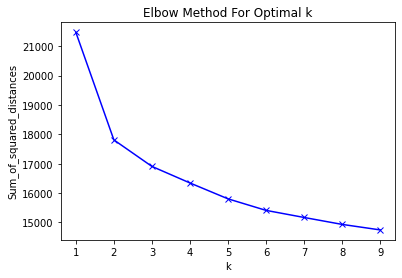

In [18]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
kmeans = KMeans(n_clusters=3)  
kmeans.fit(df_train['vec'].values.tolist())

KMeans(n_clusters=3)

In [20]:
df_train['cluster'] = kmeans.fit_predict(df_train['vec'].values.tolist())

In [21]:
df_train

,index,x,label,text,vec,cluster
0,0,i dunno justin read my mention or not . only j...,1,<user> i dunno justin read my mention or not ....,"[-0.13441017, -0.030572182, 0.014907515, -0.00...",1
1,1,"because your logic is so dumb , i won't even c...",1,"because your logic is so dumb , i won't even c...","[-0.14094146, -0.058948137, -0.013676152, 0.00...",2
2,2,""" just put casper in a box ! "" looved the bat...",1,""" <user> just put casper in a box ! "" looved t...","[-0.15495925, -0.06678104, -0.011773438, 0.043...",2
3,3,thanks sir > > don't trip lil mama ... just ke...,1,<user> <user> thanks sir > > don't trip lil ma...,"[-0.09147074, -0.055073876, -0.024314003, 0.00...",1
4,4,visiting my brother tmr is the bestest birthda...,1,visiting my brother tmr is the bestest birthda...,"[-0.18109384, -0.032783825, 0.020627666, -0.03...",1
...,...,...,...,...,...,...
199995,199995,can't wait to fake tan tonight ! hate being pale,0,can't wait to fake tan tonight ! hate being pa...,"[-0.14952473, -0.054160025, 0.043929067, -0.01...",1
199996,199996,darling i lost my internet connection .. and i...,0,<user> darling i lost my internet connection ....,"[-0.15076579, -0.043317128, 0.016784294, 0.007...",2
199997,199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0,kanguru defender basic 4 gb usb 2.0 flash driv...,"[-0.075457595, -0.078492776, 0.012882757, 0.00...",0
199998,199998,rizan is sad now,0,rizan is sad now\n,"[-0.11935461, -0.05930296, 0.07499723, -0.0056...",2


In [22]:
df_train.groupby(['cluster'])['label'].value_counts()

cluster  label
0        0        30896
         1         2046
1        1        48344
         0        32820
2        1        49610
         0        36284
Name: label, dtype: int64

In [23]:
pca = PCA(n_components=3)
df_train['x1'] = pca.fit_transform(df_train['vec'].values.tolist())[:,0]
df_train['y1'] = pca.fit_transform(df_train['vec'].values.tolist())[:,1]
df_train['z1'] = pca.fit_transform(df_train['vec'].values.tolist())[:,2]


print(pca.explained_variance_ratio_)



[0.23123837 0.06487994 0.04181419]


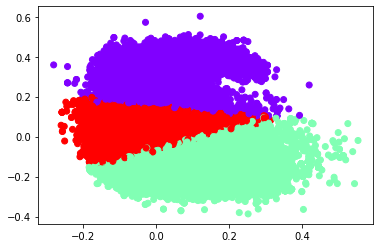

In [24]:
plt.scatter(df_train['y1'],df_train['x1'], c=df_train['cluster'], cmap='rainbow')

Text(0.5, 0.92, 'Tweet Clustering using K Means')

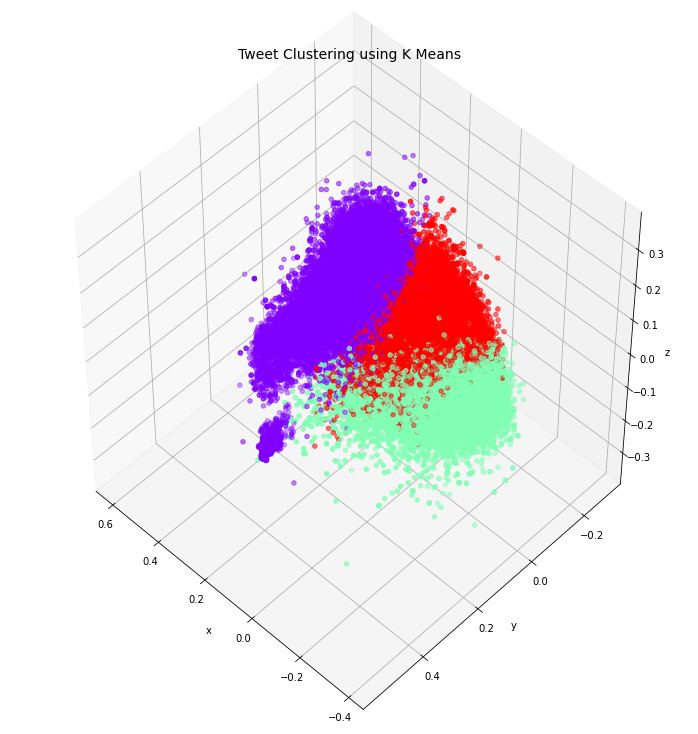

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(df_train['x1'],df_train['y1'],df_train['z1'], c=df_train['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Tweet Clustering using K Means", fontsize=14)



In [26]:
dfc = df_train.filter(['index', 'text', 'label', 'cluster'], axis=1)
dfc
dfc.to_csv("/content/gdrive/MyDrive/ClusteredFasttextSmallTrainUnpreprocessed")

In [27]:
dfc

,index,text,label,cluster
0,0,<user> i dunno justin read my mention or not ....,1,1
1,1,"because your logic is so dumb , i won't even c...",1,2
2,2,""" <user> just put casper in a box ! "" looved t...",1,2
3,3,<user> <user> thanks sir > > don't trip lil ma...,1,1
4,4,visiting my brother tmr is the bestest birthda...,1,1
...,...,...,...,...
199995,199995,can't wait to fake tan tonight ! hate being pa...,0,1
199996,199996,<user> darling i lost my internet connection ....,0,2
199997,199997,kanguru defender basic 4 gb usb 2.0 flash driv...,0,0
199998,199998,rizan is sad now\n,0,2
